In [35]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from tqdm import tqdm
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from config import countries

In [31]:
load_dotenv()
engine = create_engine(os.getenv("SQLALCHEMY_DATABASE_URI"))

In [38]:
master_df = pd.DataFrame()
for cty in countries.keys():
    sql_table_name = f"{cty}_dap"
    df = pd.read_sql_table(sql_table_name, engine)
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df.set_index("DateTime", inplace=True)
    # rename columns
    df.rename(columns={"0": cty}, inplace=True)
    if master_df.empty:
        master_df = df
    else:
        master_df = master_df.join(df, how="outer")
# drop rows with NaN
master_df.dropna(inplace=True)
# keep only the first 750 rows
master_df = master_df.head(750)
print(master_df.head())
print(master_df.tail())

                        BE      DK     FR     DE      IE     LU     NL  \
DateTime                                                                 
2015-01-04 23:00:00  36.56  28.625  36.56  22.34  49.140  22.34  36.56   
2015-01-05 00:00:00  34.94  28.515  34.94  17.93  37.840  17.93  34.94   
2015-01-05 01:00:00  32.19  28.500  32.19  15.17  43.715  15.17  32.19   
2015-01-05 02:00:00  28.05  28.050  23.53  16.38  47.905  16.38  28.05   
2015-01-05 03:00:00  28.04  28.690  22.92  17.38  48.385  17.38  28.04   

                         NO     CH       UK  
DateTime                                     
2015-01-04 23:00:00  28.538  37.80  42.8600  
2015-01-05 00:00:00  28.442  34.09  37.1950  
2015-01-05 01:00:00  28.426  31.89  39.8925  
2015-01-05 02:00:00  28.418  28.50  41.7025  
2015-01-05 03:00:00  28.560  27.23  41.3375  
                        BE     DK     FR     DE     IE     LU     NL     NO  \
DateTime                                                                      
2

In [33]:
def train_svr(ftr_ctys, tgt_cty):
    # split the data
    X = master_df[ftr_ctys]
    y = master_df[tgt_cty]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # train the model
    model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    fig = plt.figure(figsize=(12, 12))
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.axis("equal")
    plt.axis("square")
    plt.xlim([0, plt.xlim()[1]])
    plt.ylim([0, plt.ylim()[1]])
    _ = plt.plot([-1000, 1000], [-1000, 1000], color="red")
    return {
        "ftr_ctys": ftr_ctys,
        "tgt_cty": tgt_cty,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "model": model,
        "fig": fig,
    }

100%|██████████| 10/10 [00:00<00:00, 36.22it/s]


  cty       mae         mse       rmse        r2
0  BE  1.636383    6.903776   2.627504  0.926049
0  DK  2.224155   18.926386   4.350447  0.779556
0  FR  2.077914   18.953974   4.353616  0.839697
0  DE  1.648193   13.544702   3.680313  0.921571
0  IE  9.704746  358.670999  18.938611  0.513017
0  LU  1.648193   13.544702   3.680313  0.921571
0  NL  2.705073   13.779453   3.712069  0.820030
0  NO  1.236624    8.488659   2.913530  0.707493
0  CH  2.872380   18.360205   4.284881  0.733808
0  UK  5.212493  115.525317  10.748270  0.652619


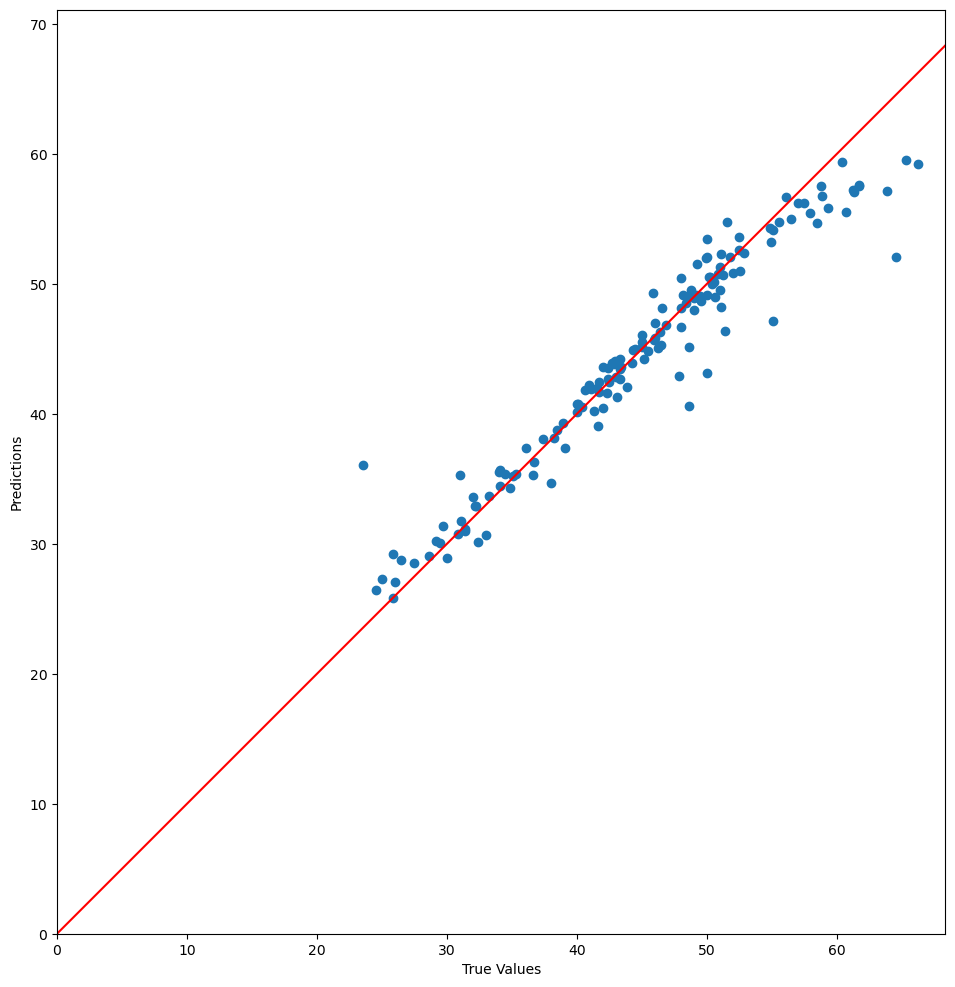

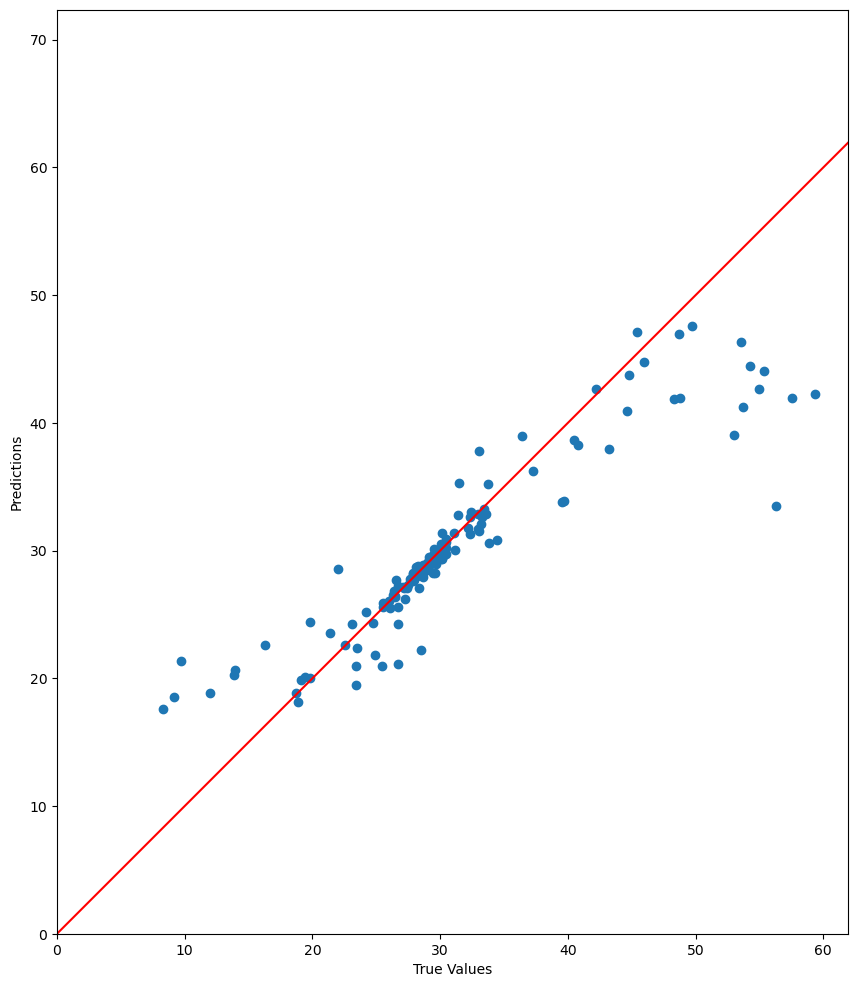

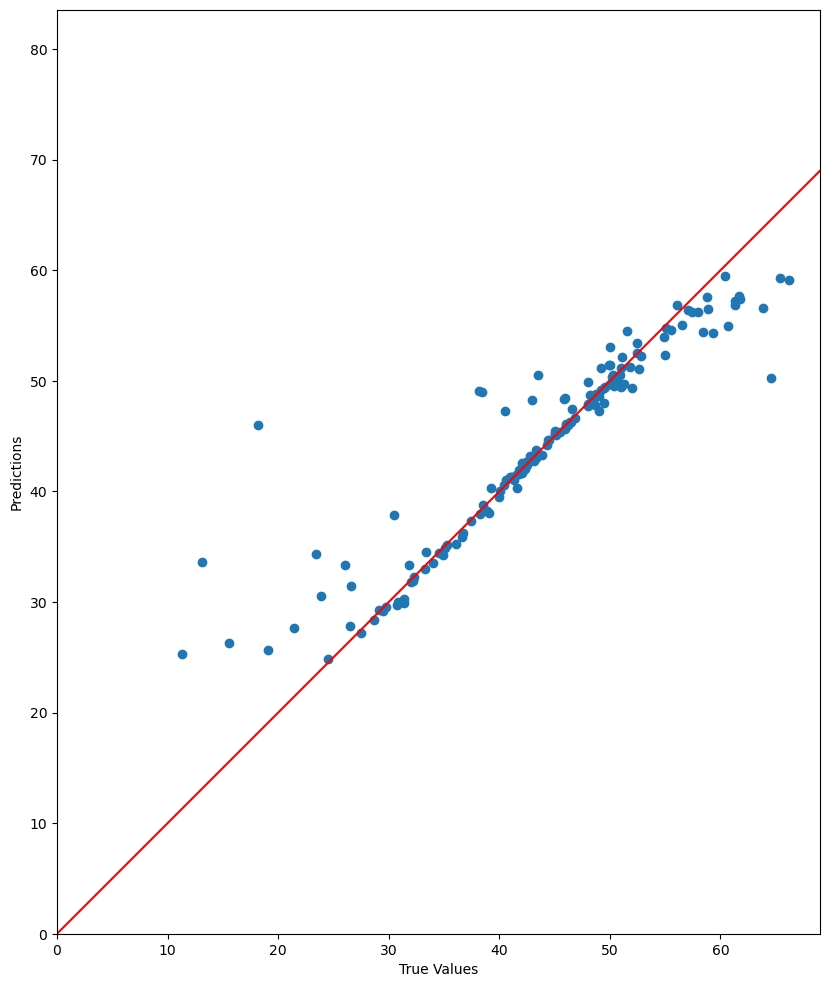

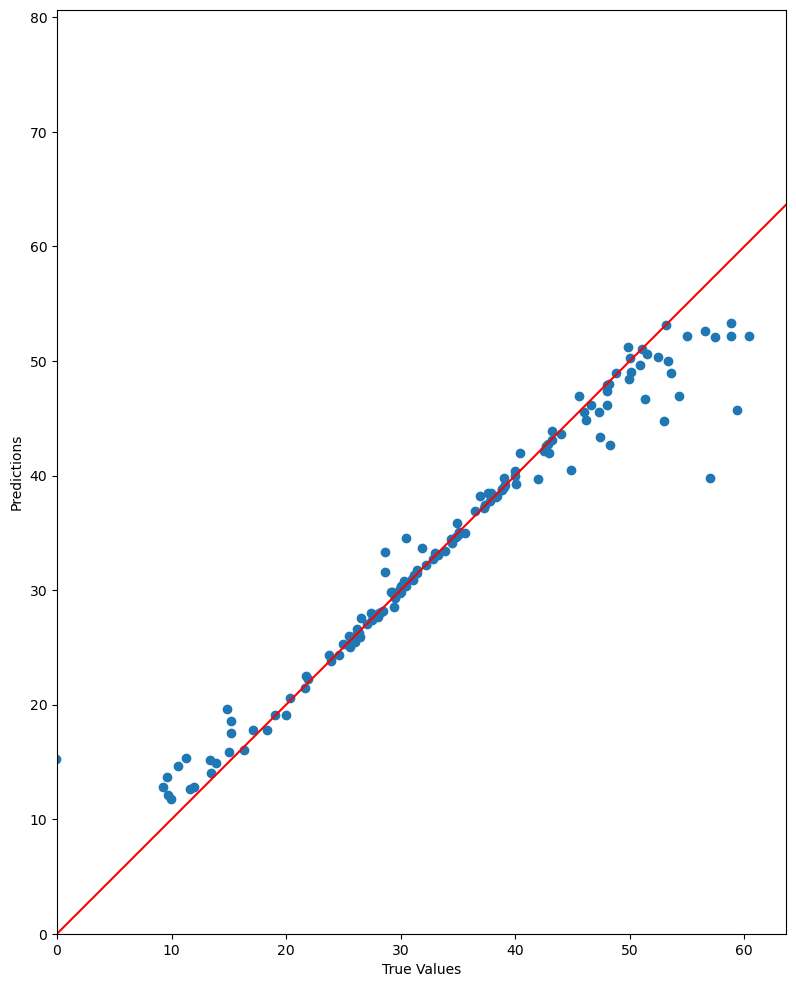

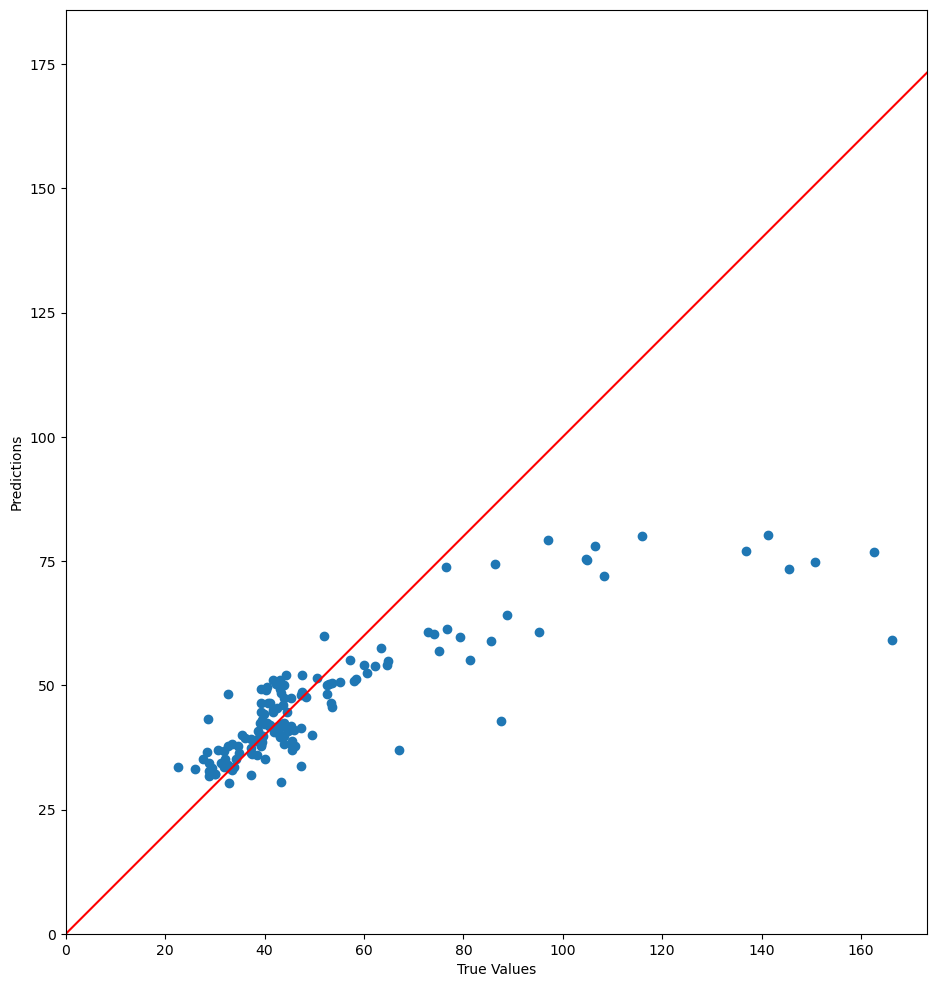

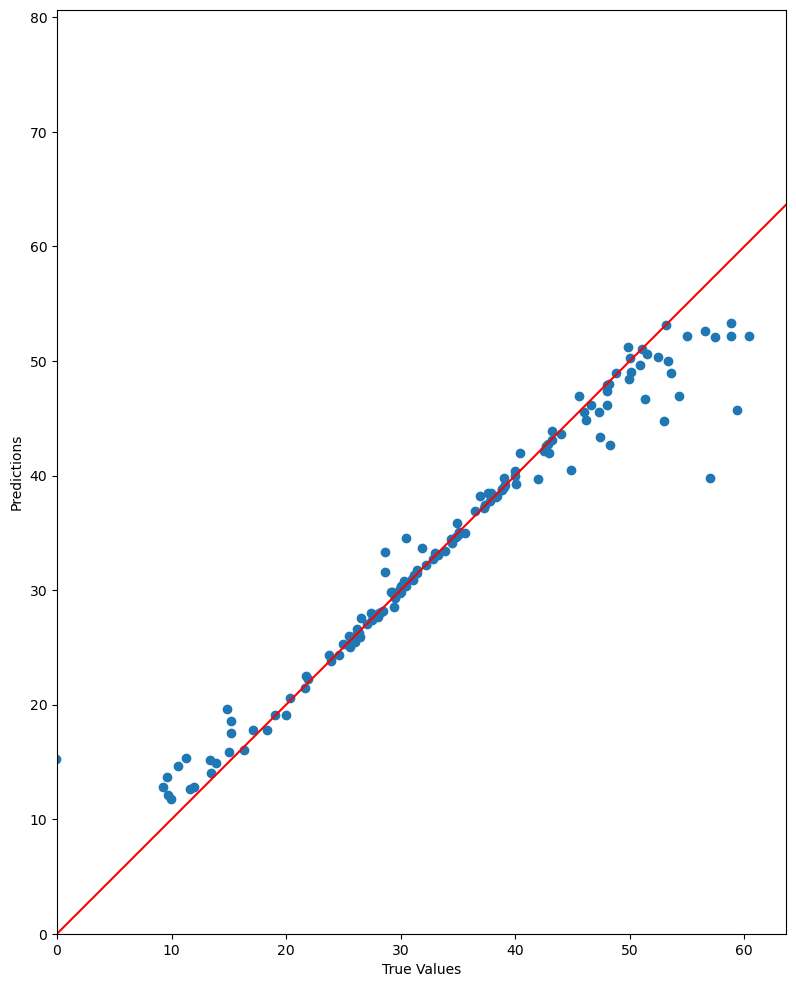

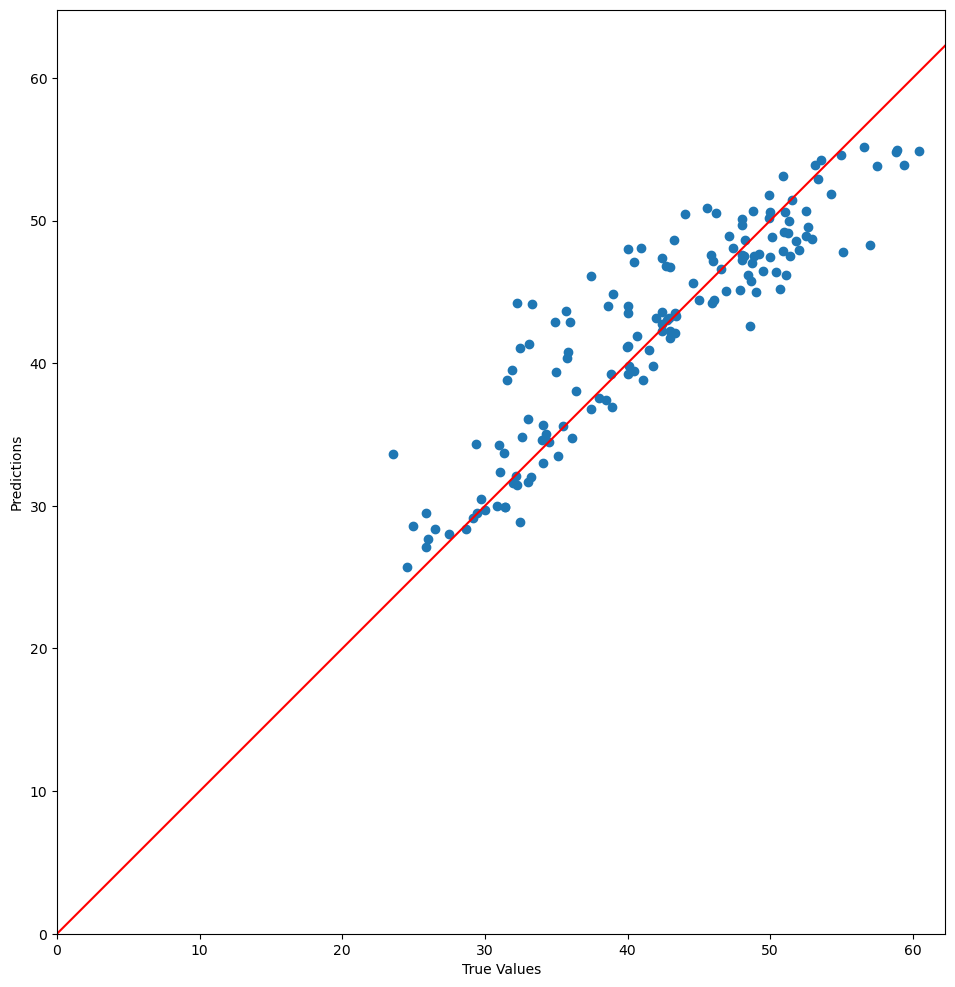

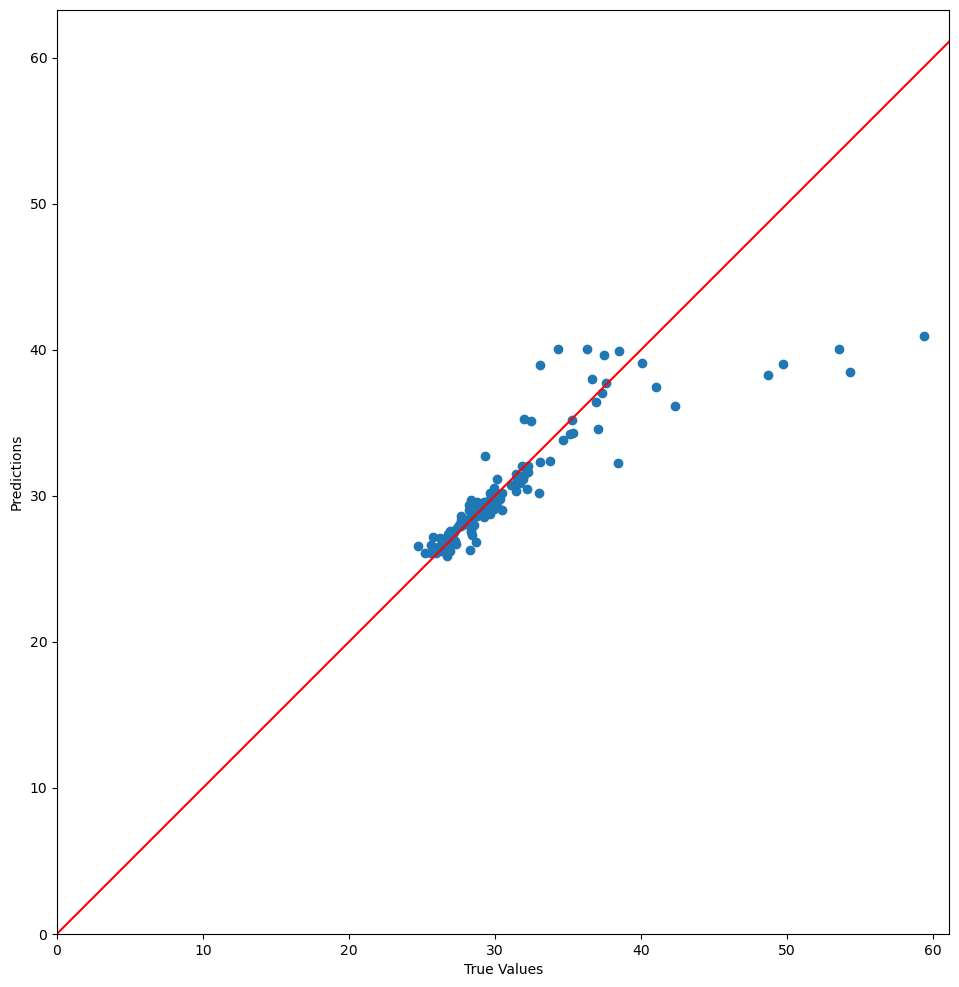

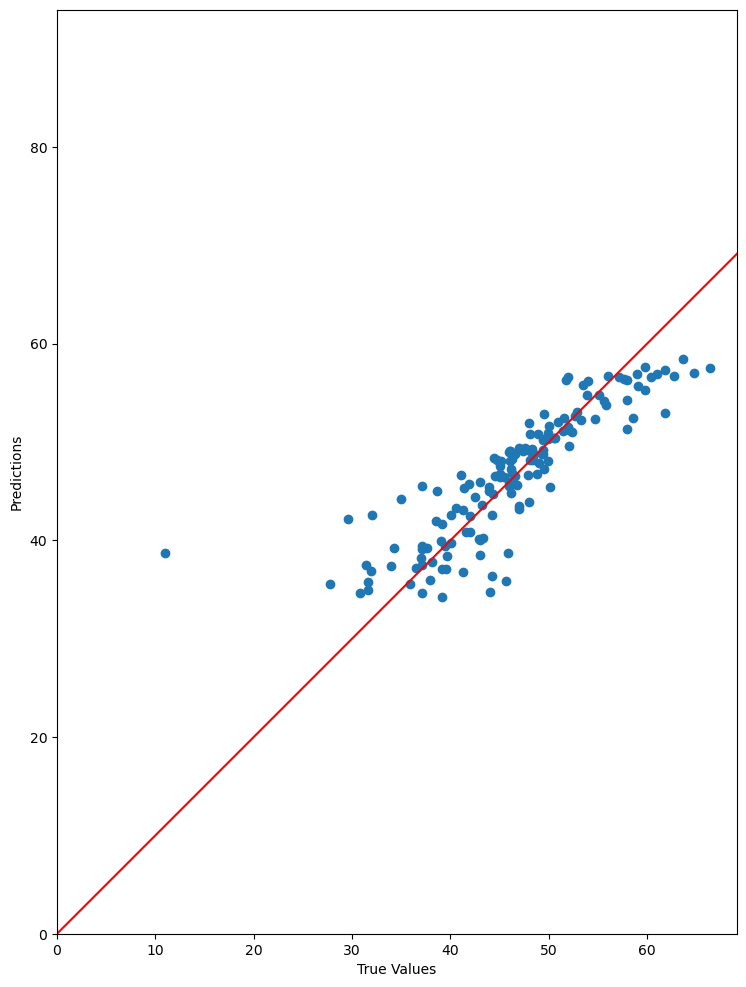

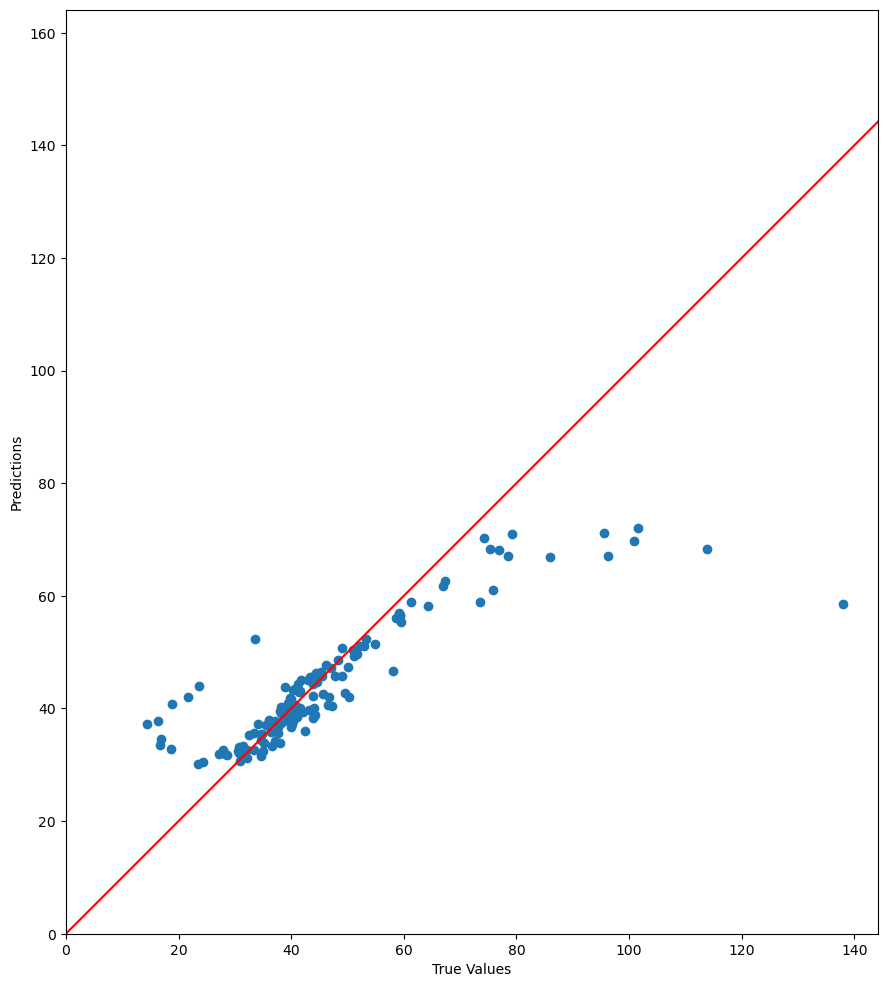

In [37]:
benchmark_df = pd.DataFrame({"cty": [], "mae": [], "mse": [], "rmse": [], "r2": []})
for cty in tqdm(countries.keys()):
    ftr_ctys = [f for f in countries.keys() if f != cty]
    record = train_svr(ftr_ctys, cty)
    row = {
        "cty": cty,
        "mae": record["mae"],
        "mse": record["mse"],
        "rmse": record["rmse"],
        "r2": record["r2"],
    }
    benchmark_df = pd.concat([benchmark_df, pd.DataFrame(row, index=[0])])

print(benchmark_df)
benchmark_df.to_latex("benchmark.tex")